# Timing Optimization for fft_rs
*September 7th 2021*

**Aim - Optimization of FFT Response Spectrum algorithm**
- Test using numpy broadcasting to vectorize the fft operation for all spring frequencies at once.
- Test using custom FFT libraries other than numpy.

In [74]:
# Standard library imports
import os
import sys
from time import perf_counter

# Third party imports
import numpy as np
from numpy.lib.recfunctions import structured_to_unstructured
import matplotlib.pyplot as plt
from scipy.signal import resample

# Add project root to path
pkg_path = os.path.abspath("..")
if pkg_path not in sys.path:
    sys.path.insert(0, os.path.abspath(".."))

# Local application imports
from autoRS import array_like_1d

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup Environment

In [11]:
th_path = os.path.join("../tests", "test_resources", "multi_col.csv",)
th_raw = np.genfromtxt(
        th_path,
        delimiter=",",
        skip_header=1,
        names=True,
        deletechars=" !#$%&'()*+,-./:;<=>?[\\]^{|}~",
    )

# Convert to unstructured ndarray and remove nan values (last column)
th_raw = structured_to_unstructured(th_raw)
time = th_raw[:, 0]
acc = th_raw[:, 1]

In [77]:
# Get downsampled and upsampled versions of TH to test algorithm on various sizes of inputs
low_acc, low_time = resample(acc, len(acc)//10, t=time)
high_acc, high_time = resample(acc, len(acc)*10, t=time)

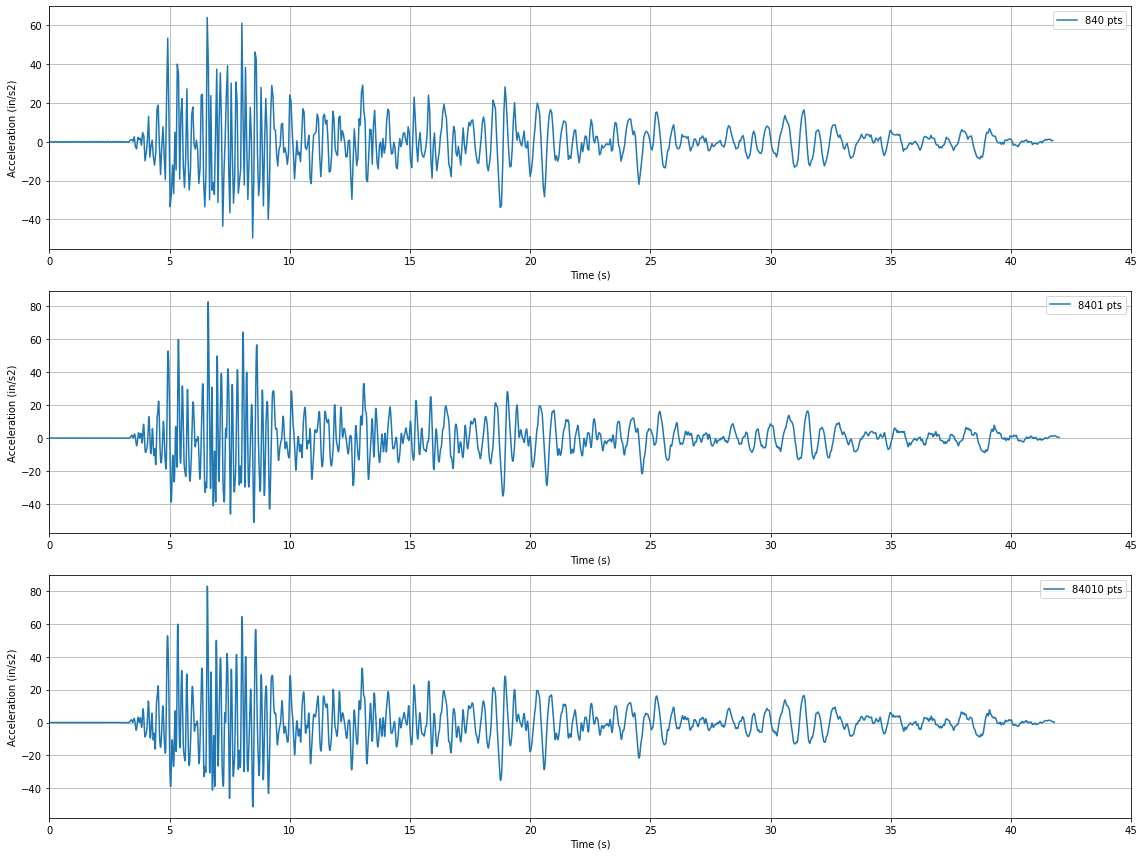

In [80]:
# Plot example TH
fig, axes = plt.subplots(3, figsize=(16, 12))
axes[1].plot(time, acc, label=f"{len(acc)} pts")
axes[0].plot(low_time, low_acc, label=f"{len(low_acc)} pts")
axes[2].plot(high_time, high_acc, label=f"{len(high_acc)} pts")
for ax in axes:
    ax.grid(which='both')
    ax.set(
        xlim=(0, 45),
        xlabel="Time (s)",
        ylabel="Acceleration (in/s2)",   
    )
    ax.legend()
plt.tight_layout()

## Define Curent Response Spectrum algorithm (with a for loop impleentation)

In [15]:
def _fft_rs(
    acc: array_like_1d, time: array_like_1d, frqs: array_like_1d, zeta: float = 0.05,
) -> [np.ndarray, np.ndarray]:
    """Generate acceleration response spectrum using a frequency domain
    method at the given frequencies. This is physically accurate if the true
    acceleration time history has no frequency content higher than the nyquist
    frequency of the input acceleration.

    Parameters
    ----------
    acc : 1d array_like
        Input 1D acceleration time history.
    time : 1d array_like
        Input 1D time values for the acceleration time history, `acc`.
    frqs : 1d array_like
        1D array of frequencies where the response is calculated.
    zeta : float, optional
        Critical damping ratio (dimensionless). Defaults to 0.05. Should be between 0
        and 1.

    Returns
    -------
    rs : ndarray
        Array with spectral accelerations (same units as input acc).
    frqs : ndarray
        Array with frequencies in Hz. Same as `frequencies`.
    """

    # Enforce ndarray type
    frqs = np.asarray(frqs)

    # Instantiate angular frequency and spectral acceleration arrays
    w = frqs * 2 * np.pi
    rs = 0 * w

    # Define minimum timestep from input signal
    dt_min = time[1] - time[0]

    # Calculate n, the integer to determine 0 padding at the end
    # of the time history; making n a power of 2 improves the
    # efficiency of the fft algorithm
    n = len(acc)
    n_fft = int(2 ** (np.ceil(np.log(1.5 * n) / np.log(2))))

    # Get n for upsampling by sinc-interpolating so there are
    # `multiplier` times as many points
    multiplier = 8

    # Get FFT of input acceleration
    xgfft = np.fft.rfft(acc, n_fft)
    frqt = np.fft.rfftfreq(n_fft, d=dt_min)

    # Calculate response for a spring with each wn
    for k, wn in enumerate(w):

        # Angular frequencies of fft
        wf = frqt * 2 * np.pi

        # Displacement of spring mass (fourier terms)
        xfft = -xgfft / (-(wf ** 2) + 2 * zeta * wn * 1j * wf + wn ** 2)

        # Relative acceleration of spring mass (fourier terms)
        accfft = -xfft * wf ** 2

        # Absolute acceleration of spring mass (fourier terms)
        abs_accfft = accfft + xgfft

        # Get absolute acceleration of spring mass (time domain)
        # Up-sample so that the final time history is sinc-
        # interpolated with `n_multiplier` total points
        a = np.fft.irfft(abs_accfft, n=multiplier * n_fft) * multiplier

        # Peak absolute acceleration of spring mass
        rs[k] = np.max(np.absolute(a))

    return rs, frqs

## Define Response Spectrum algorithm with numpy array broadcasting

In [71]:
def new_fft_rs(
    acc: array_like_1d, time: array_like_1d, frqs: array_like_1d, zeta: float = 0.05,
) -> [np.ndarray, np.ndarray]:


    # Enforce ndarray type
    frqs = np.asarray(frqs)

    # Instantiate angular frequency and spectral acceleration arrays
    wn = frqs.reshape((1, -1)) * 2 * np.pi

    # Define minimum timestep from input signal
    dt_min = time[1] - time[0]

    # Calculate n, the integer to determine 0 padding at the end
    # of the time history; making n a power of 2 improves the
    # efficiency of the fft algorithm
    n = len(acc)
    n_fft = int(2 ** (np.ceil(np.log(1.5 * n) / np.log(2))))

    # Get n for upsampling by sinc-interpolating so there are
    # `multiplier` times as many points
    multiplier = 8

    # Get FFT of input acceleration
    xgfft = np.fft.rfft(acc, n_fft).reshape((-1, 1))
    frqt = np.fft.rfftfreq(n_fft, d=dt_min).reshape((-1, 1))


    # Angular frequencies of fft
    wf = frqt * 2 * np.pi

    # Displacement of spring mass (fourier terms)
    xfft = -xgfft / (-(wf ** 2) + 2 * zeta * wn * 1j * wf + wn ** 2)

    # Relative acceleration of spring mass (fourier terms)
    accfft = -xfft * wf ** 2
    
    # Absolute acceleration of spring mass (fourier terms)
    abs_accfft = accfft + xgfft
    
    # Get absolute acceleration of spring mass (time domain)
    # Up-sample so that the final time history is sinc-
    # interpolated with `n_multiplier` total points
    a = np.fft.irfft(abs_accfft, n=multiplier * n_fft, axis=0) * multiplier
    
    # Peak absolute acceleration of spring mass
    rs = np.max(np.absolute(a), axis=0).flatten()

    return rs, frqs

## Timing of RS implementations

In [81]:
%%timeit
_fft_rs(low_acc, low_time, autoRS.spectrum.get_default_frequencies())

68 ms ± 627 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [82]:
%%timeit
_fft_rs(acc, time, autoRS.spectrum.get_default_frequencies())

1.12 s ± 36.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [83]:
%%timeit
_fft_rs(high_acc, high_time, autoRS.spectrum.get_default_frequencies())

9.7 s ± 76.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [84]:
%%timeit
new_fft_rs(low_acc, low_time, autoRS.spectrum.get_default_frequencies())

124 ms ± 2.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [85]:
%%timeit
new_fft_rs(acc, time, autoRS.spectrum.get_default_frequencies())

1.25 s ± 21.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [86]:
%%timeit
new_fft_rs(high_acc, high_time, autoRS.spectrum.get_default_frequencies())

10.9 s ± 410 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Conclusion**

Across various sizes of FFTs, the current implementation of a for loop over the spring frequencies is slightly more efficient. It is also preferable since it is easier to understand without requiring numpy array broadcasting knowledge.